## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo

In [21]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [82]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [23]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [24]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
1030,30455,2012-09-20,NaT,2013-02-07,2013-03-01,BA,30.00,2011-11-01,2011-11-10,2011-12-01,...,2012-09-22,NaT,NaT,NaT,NaT,EOL,1,30.00,bdworgs,None
4566,40881,2020-12-22,2020-12-30,2020-11-21,2021-04-30,CE,16800.00,2020-04-27,2019-10-29,2020-05-18,...,None,NaT,NaT,2019-06-01,2019-12-03,EOL,2,8400.00,skate,2019-07-02
3978,37620,2025-05-01,2025-06-01,NaT,NaT,PI,44400.00,2024-01-01,NaT,NaT,...,None,NaT,NaT,2024-03-31,NaT,UFV,1,44400.00,skate,2022-04-19
2969,33025,2022-12-02,2023-01-01,2020-12-17,2021-01-28,PI,27000.00,2022-03-15,2019-11-15,2022-05-01,...,None,NaT,NaT,2022-04-01,2019-05-05,EOL,3,9000.00,skate,2018-05-29
242,28607,2013-04-30,2016-08-25,2016-03-02,2016-05-07,MG,24.00,2002-09-30,2014-02-28,2003-03-31,...,None,NaT,2016-03-30,NaT,2014-12-11,PCH,1,12.00,bdworgs,None
3541,35242,2022-11-20,2022-12-31,2021-10-09,2021-11-20,PB,13860.00,2021-10-17,2020-09-14,2021-12-17,...,None,NaT,NaT,2021-10-17,2020-08-14,EOL,1,3465.00,skate,2019-01-29
4542,40864,2022-01-01,2022-04-01,NaT,NaT,MG,51450.00,2021-05-01,2021-03-15,NaT,...,None,NaT,NaT,2021-02-01,2021-05-15,UFV,33,49999.95,skate,2019-12-17
2800,32485,2023-05-25,2023-06-09,NaT,NaT,CE,38500.00,2022-05-01,NaT,2022-11-16,...,None,NaT,NaT,2022-04-01,NaT,EOL,1,5500.00,skate,2022-02-01
1052,30490,2014-09-10,2014-10-10,2014-09-10,2014-10-11,BA,21.84,2011-11-30,2013-02-28,2011-12-15,...,2013-05-15,NaT,NaT,2012-01-30,2013-05-01,EOL,13,21.84,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [25]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy(deep=True)

#### Cria dicionário com o tempo de cada marco a até a DatLiberOpComerRealizado por cada UG

In [6]:
dict_nome_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_nome_marco.items()}


tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao","origem"]].copy(deep=True)
for nome,marco in dict_nome_marco.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
24,912,UTE,bdworgs,722 days,NaT,NaT,184 days,63 days
25,1146_0,UHE,bdworgs,1527 days,NaT,NaT,52 days,0 days
26,1146_1,UHE,bdworgs,1602 days,NaT,NaT,98 days,0 days


In [37]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso","origem"]],2))
motivo_eliminacao = tempo_construcao_por_UG[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[mask_ordem_correta].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [8]:
# Retirada as inconcistências
idx_primeira_ug =  bd_combined[mask_ordem_correta].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
1826,32286,2015-07-15,2015-07-15,2016-09-14,2016-10-01,RO,18.00,2015-05-14,2015-10-15,NaT,...,None,NaT,NaT,NaT,2015-11-30,UTE,18,18.00,bdworgs,None
1526,31425,2017-01-18,2017-01-20,2016-11-04,2016-11-15,RN,27.30,2016-02-05,2015-08-15,2016-08-03,...,2016-09-30,NaT,NaT,2016-01-11,2015-08-15,EOL,4,8.40,bdworgs,None
1178,30725,2013-08-06,2013-09-01,2017-08-23,2017-12-01,BA,29.90,2012-11-01,2013-04-01,2013-02-01,...,2013-11-08,NaT,NaT,2012-11-01,2012-11-06,EOL,13,29.90,bdworgs,None
1085,30537,2012-11-21,2012-12-11,2015-12-23,2016-01-30,RN,30.00,2012-03-01,2012-09-01,2012-05-02,...,2013-03-01,NaT,NaT,2011-10-01,2013-01-01,EOL,15,30.00,bdworgs,None
3672,35818,2019-04-25,2019-06-04,2019-12-06,2020-12-03,AM,4224.00,2018-06-06,2019-02-06,NaT,...,None,NaT,NaT,2019-02-13,2019-07-01,UTE,12,4224.00,skate,2016-08-16
574,29588,2008-06-03,2008-07-15,2008-05-12,2008-07-22,GO,80.00,NaT,2007-05-07,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,40.00,bdworgs,None
470,29161,2005-11-14,2006-01-02,2005-12-10,2006-02-04,AL,32.00,NaT,2003-09-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,16.00,bdworgs,None
1181,30731,2014-06-11,2014-07-01,2016-01-08,2016-02-05,BA,16.65,2013-09-14,2013-10-15,2013-10-14,...,2014-11-15,NaT,NaT,2013-09-08,2013-09-02,EOL,9,16.65,bdworgs,None
970,30354_9,2016-07-31,2016-09-30,2016-12-09,2017-01-18,PA,11233.10,2011-05-31,2011-08-18,2013-01-31,...,None,2014-12-15,2015-11-24,2014-03-31,2014-09-30,UHE,1,611.11,bdworgs,None


In [9]:
# Considera apenas a primeira UG a entrar em OC
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,bdworgs,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,bdworgs,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,bdworgs,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,bdworgs,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5763,50872,UTE,skate,98 days,NaT,98 days,41 days,-920 days
5787,51444,UTE,skate,99 days,NaT,99 days,22 days,-385 days
5793,51450,UTE,skate,104 days,NaT,104 days,26 days,-380 days


In [45]:
dict_tempo_construcao_mean_dp["UHE"]

{'IO_OC': {'media': Timedelta('1845 days 12:18:46.956521728'),
  'dp': Timedelta('613 days 22:04:08.961484144')},
 'CC_OC': {'media': Timedelta('1621 days 03:27:45.671641792'),
  'dp': Timedelta('604 days 11:20:44.069674760')},
 'ME_OC': {'media': Timedelta('1516 days 07:42:13.333333328'),
  'dp': Timedelta('625 days 13:02:25.263805792')},
 'OT_OC': {'media': Timedelta('50 days 23:23:04.615384615'),
  'dp': Timedelta('63 days 23:29:57.329139065')},
 'Atraso': {'media': Timedelta('204 days 04:02:01.008403362'),
  'dp': Timedelta('555 days 01:50:12.238676440')}}

In [76]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = bd_combined.SigTipoGeracao.unique()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
dict_tempo_construcao_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_tempo_construcao_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = (tempo_construcao_por_usina.loc[mask,tempo]).mean()
        s= (tempo_construcao_por_usina.loc[mask,tempo]).std()
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["media"] = m
        dict_tempo_construcao_mean_dp[SigTipoGeracao][tempo]["dp"] = s      
tempo_construcao_por_usina_norm.sample(15)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
1577,31538,EOL,-0.524555,-0.337461,NaT,-0.260246,-0.079991
3665,35810,UTE,-0.40621,NaT,-0.380958,0.009538,-0.093113
559,29512,UTE,-0.24768,NaT,NaT,0.848091,-0.054587
616,29686,PCH,-0.594667,-0.471399,-0.595254,-0.123856,-1.010415
1834,32296,UTE,-0.732442,NaT,-0.480472,-0.464149,-0.034611
612,29668,UTE,-0.390488,NaT,-0.290045,-0.380934,-0.375633
526,29434,PCH,0.139601,-0.231343,-0.490615,0.029135,-1.105413
672,29709,UTE,-0.349873,NaT,-0.438701,-0.47055,-0.287167
418,29067,PCH,-0.198989,-0.553524,-0.912659,-0.020362,1.051136


In [93]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao","origem"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,IO_OC_std,CC_OC_media,CC_OC_std,ME_OC_media,ME_OC_std,OT_OC_media,OT_OC_std,Atraso_media,Atraso_std
SigTipoGeracao,,,,,,,,,,
UHE,1845 days 12:18:46.956521728,613 days 22:04:08.961484144,1621 days 03:27:45.671641792,604 days 11:20:44.069674760,1516 days 07:42:13.333333328,625 days 13:02:25.263805792,50 days 23:23:04.615384615,63 days 23:29:57.329139065,204 days 04:02:01.008403362,555 days 01:50:12.238676440
UTE,685 days 01:03:05.567010312,763 days 06:13:57.232163984,NaT,NaT,517 days 02:03:34.925373136,813 days 23:05:40.321114920,104 days 12:14:24,156 days 05:18:50.871896478,299 days 06:09:24.370546320,700 days 20:02:22.453115912
PCH,876 days 02:01:03.716814160,507 days 23:43:17.432072712,644 days 20:41:08.571428568,474 days 21:19:07.127639624,402 days 15:49:56.858638744,286 days 16:48:39.477836580,50 days 12:36:08.339768340,222 days 05:37:25.697446476,993 days 17:03:00.694980688,1021 days 01:48:42.165772656
CGH,895 days 13:55:12,552 days 23:12:08.916062312,666 days 22:28:05.106382976,466 days 09:12:43.861994504,480 days 01:12:00,400 days 10:17:45.385340680,103 days 00:48:48.813559322,120 days 13:26:52.069406274,415 days 05:36:00,743 days 19:46:10.268040512
EOL,561 days 17:28:45.746799432,361 days 16:38:45.064584064,493 days 03:34:14.935622320,359 days 00:01:04.912588796,357 days 22:04:08.275862068,415 days 13:30:35.749031500,58 days 14:10:04.267425320,40 days 16:38:34.517715014,66 days 12:15:21.763869132,568 days 22:43:13.340472880
UFV,376 days 21:46:29.403973508,118 days 01:40:47.919473070,NaT,NaT,244 days 08:09:36,111 days 05:59:33.541144490,70 days 22:24:38.145695364,59 days 07:32:42.366599958,-5 days +20:20:39.735099338,291 days 20:06:14.344610156


In [84]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in dict_nome_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [85]:
marco_medio_usina

,IdeUsinaOutorga,SigTipoGeracao,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,,
0,12_0,UHE,2002-02-09 11:41:13.043478272,2002-09-21 20:32:14.328358208,2003-01-04 16:17:46.666666672,2007-01-09 00:36:55.384615385
1,12_1,UHE,2003-08-13 11:41:13.043478272,2004-03-24 20:32:14.328358208,2004-07-07 16:17:46.666666672,2008-07-12 00:36:55.384615385
2,19,UTE,2000-02-15 22:56:54.432989688,NaT,2000-08-01 21:56:25.074626864,2001-09-18 11:45:36.000000000
3,42_0,UHE,1998-11-10 11:41:13.043478272,1999-06-22 20:32:14.328358208,1999-10-05 16:17:46.666666672,2003-10-10 00:36:55.384615385
4,42_1,UHE,2000-08-11 11:41:13.043478272,2001-03-23 20:32:14.328358208,2001-07-06 16:17:46.666666672,2005-07-11 00:36:55.384615385
5,42_2,UHE,2000-10-12 11:41:13.043478272,2001-05-24 20:32:14.328358208,2001-09-06 16:17:46.666666672,2005-09-11 00:36:55.384615385
6,127,UTE,2000-05-31 22:56:54.432989688,NaT,2000-11-15 21:56:25.074626864,2002-01-02 11:45:36.000000000
7,161,PCH,2000-12-05 21:58:56.283185840,2001-07-25 03:18:51.428571432,2002-03-24 08:10:03.141361256,2003-03-11 11:23:51.660231660
9,291,PCH,2001-08-06 21:58:56.283185840,2002-03-26 03:18:51.428571432,2002-11-23 08:10:03.141361256,2003-11-10 11:23:51.660231660


In [79]:
marco

'DatLiberacaoSFGTeste'

In [14]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in dict_nome_marco.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [88]:
dict_atraso_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    dict_atraso_mean_dp[SigTipoGeracao] = {}
    for marco in dict_marco_nome.keys():
        marco += "_atraso"
        dict_atraso_mean_dp[SigTipoGeracao][marco] = {}
        mask = atraso_usina.SigTipoGeracao==SigTipoGeracao
        m = atraso_usina.loc[mask,marco].mean()
        s= atraso_usina.loc[mask,marco].std()
        dict_atraso_mean_dp[SigTipoGeracao][marco]["media"] = m
        dict_atraso_mean_dp[SigTipoGeracao][marco]["dp"] = s

In [95]:
pd.DataFrame(dict_atraso_mean_dp)

,UHE,UTE,PCH,CGH,EOL,UFV
DatInicioObraRealizado_atraso,"{'media': 193 days 06:34:26.086956510, 'dp': 7...","{'media': 302 days 07:47:37.731958756, 'dp': 8...","{'media': 1014 days 05:56:48.849557504, 'dp': ...","{'media': 494 days 13:55:12, 'dp': 485 days 23...","{'media': 66 days 12:15:21.763869129, 'dp': 42...","{'media': -5 days +20:20:39.735099334, 'dp': 3..."
DatConcretagemRealizado_atraso,"{'media': 210 days 23:38:30.447761200, 'dp': 7...","{'media': NaT, 'dp': NaT}","{'media': 971 days 17:22:17.142857136, 'dp': 9...","{'media': 508 days 04:35:44.680851056, 'dp': 5...","{'media': 61 days 10:32:26.781115884, 'dp': 40...","{'media': NaT, 'dp': NaT}"
DatMontagemRealizado_atraso,"{'media': 45 days 00:26:39.999999990, 'dp': 65...","{'media': 297 days 02:35:49.253731336, 'dp': 9...","{'media': 876 days 20:59:03.455497408, 'dp': 9...","{'media': 548 days 03:36:00, 'dp': 585 days 03...","{'media': 96 days 15:18:37.241379309, 'dp': 50...","{'media': -8 days +21:07:12, 'dp': 310 days 21..."
DatLiberacaoSFGTeste_atraso,"{'media': 207 days 15:53:50.769230770, 'dp': 5...","{'media': 285 days 00:36:00, 'dp': 659 days 23...","{'media': 993 days 17:03:00.694980688, 'dp': 1...","{'media': 423 days 07:43:43.728813560, 'dp': 7...","{'media': 66 days 12:15:21.763869130, 'dp': 56...","{'media': -5 days +20:20:39.735099337, 'dp': 2..."


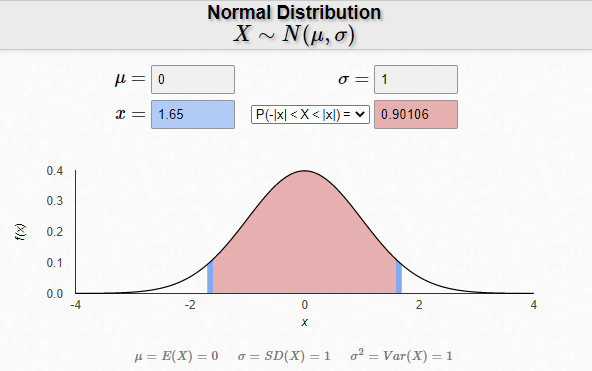

In [94]:
nomes_colunas_atrasos

['DatInicioObraRealizado_atraso',
 'DatConcretagemRealizado_atraso',
 'DatMontagemRealizado_atraso',
 'DatLiberacaoSFGTeste_atraso']

Não foi possível calcular: DatConcretagemRealizado_atraso para UTE: zero-size array to reduction operation minimum which has no identity
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV: zero-size array to reduction operation minimum which has no identity


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,68.5%,70.2%,38.9%,99.9%
UTE,80.8%,-,79.6%,99.3%
PCH,96.1%,96.9%,98.6%,99.8%
CGH,69.2%,87.1%,92.2%,99.7%
EOL,88.8%,88.4%,91.7%,99.9%
UFV,94.1%,-,94.5%,99.0%


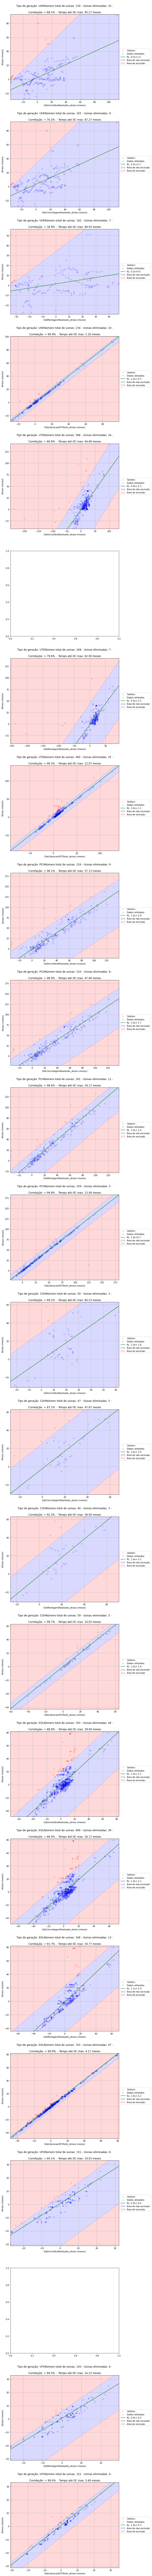

In [20]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]

matrix_pearson = {}
matrix_pearson_out = {}

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy
    


th = 1.65
   
num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
fig, axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
plot_created =True
count = -1
for i,SigTipoGeracao in enumerate(tipos_geracao):
    matrix_pearson[SigTipoGeracao] = []
    for nome_coluna in nomes_colunas_atrasos:
        count+=1
        ax = axes[count]
        try:
            # Máscara com apenas indices que correspondem ao tipo geração especificado
            idx_geracao = atraso_usina.SigTipoGeracao == SigTipoGeracao 
            # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
            x1,y1 =  extract_xy(atraso_usina[idx_geracao], nome_coluna, "Atraso", nome_coluna)/30
            x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
            m_tc = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["media"]
            dp_tc = dict_tempo_construcao_mean_dp[SigTipoGeracao][dict_marco_nome[nome_coluna[:-7]]]["dp"]
            th_tc = (th*dp_tc)+m_tc
            outliers = ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) > th_tc)| ((tempo_construcao_por_usina[dict_marco_nome[nome_coluna[:-7]]]) < -th_tc)
            x2,y2 = extract_xy(atraso_usina[idx_geracao & outliers], nome_coluna, "Atraso", nome_coluna)/30
            x3,y3 = extract_xy(atraso_usina[idx_geracao & ~outliers], nome_coluna, "Atraso", nome_coluna)/30

            a, b, r, p_value, std_err = calc_regression(x3,y3)
            p.r_str = f"{100*r:.1f}%"

            # Converte para meses
            th_tc = th_tc.days/30
            m_tc = m_tc.days/30
            dp_tc = dp_tc.days/30

            # Plota resultados
            ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
            ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
            ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
            ax.set_title(f"""\nTipo de geração: {SigTipoGeracao}Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {p.r_str}  - Tempo até OC max: {th_tc:.2f} meses""")
            ax.grid()
            #ax.plot(x_plot,x_plot-m,linewidth=2)
            ax.fill_between(x_plot,x_plot-th_tc-m_tc,x_plot+th_tc-m_tc,color="blue",alpha=0.15,label="Área de não exclusão")
            ax.fill_between(x_plot,x_plot-th_tc-m_tc,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
            ax.fill_between(x_plot,x_plot+th_tc-m_tc,y1.max(),color="red",alpha=0.15)
            ax.set_xlim(x1.min(),x1.max())
            ax.set_ylim(y1.min(),y1.max())
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_xlabel(f"{nome_coluna} (meses)")
            ax.set_ylabel(f"Atraso (meses)")
            matrix_pearson[SigTipoGeracao].append(p.r_str)
        except (ValueError,AttributeError) as error:
            print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}: {error}")
            matrix_pearson[SigTipoGeracao].append("-")
                
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)